In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D 
import os

## Loading data available

In [9]:
# Experimental Data is obtained from Bhilai steel plant and is provided for knowledge purpuse
## We will modify the data and seggregate the data as per our requirement to obtain LMTD of Heat Exchanger
# LMTD plays an important role in performance of heat exchanger
df = pd.read_csv('RareTechSEA1-60.csv')
# Shape of DataFrame
print('Shape of the Data Frame:',df.shape)
#Columns of DataFrame
print('Columns in Data Frame', df.columns)
#No. of columns
print('Number of Columns:', len(df.columns))
df.head(2)

Shape of the Data Frame: (59265, 23)
Columns in Data Frame Index(['Thickness', 'Temp1In', 'Temp1Out', 'Temp2In', 'Temp2Out',
       'Fluid1 (specific heat)', 'Fluid2', 'Q', 'Qr', 'Lmtd', 'Theta1',
       'Theta2', 'm1', 'm2', 'dP1', 'dP2', 'V1In', 'V2In', 'A', 'M', 'Ae',
       'Me', 'NP'],
      dtype='object')
Number of Columns: 23


,Thickness,Temp1In,Temp1Out,Temp2In,Temp2Out,Fluid1 (specific heat),Fluid2,Q,Qr,Lmtd,...,m2,dP1,dP2,V1In,V2In,A,M,Ae,Me,NP
0,0.4,68,63,57,67.983879,21,2,409.90869,68.318115,1.010893,...,8.880,31.118763,0.055657,0.923382,0.193251,272.0,0.0,271.0,-0.002742,544
1,0.4,41,34,30,40.912361,43,15,552.38190,276.190950,1.023957,...,12.056,65.931900,0.912950,0.481648,0.123881,661.5,1.0,655.5,1.022100,441


### Problem Statement: 
+ Given Input Parameters of fluids and temperatures and area of heat exchanger predict Logarithmic mean temperature difference.

##### Assumptions
1. Assuming the data available is for heat exchanger of same material.
2. Fouling information is not available in data and flow assumed to be counter flow.
3. Heat transfer rate is unaffected by temperature variations
4. Assuming LMTD correction factor to be one

In [10]:
# Thickness of Heat Exhanger, TempIn1, Temp2In, Fluid1 specific heat, Fluid 2 specific heat, volumetric flow rate of both fluids, mass flow rate of both fluids,
# LMTD will be our target variable, theta patterns
## Rest parameters are calculated based on outlet temperature profiles so rest will not be considered for modelling
df_clipped = df[['Thickness', 'Temp1In', 'Temp2In', 'Fluid1 (specific heat)', 'Fluid2', 'Q', 'Qr', 'Theta1', 'Theta2', 'm1', 'm2',\
                 'V1In', 'V2In', 'A']]
y = df['Lmtd']

In [11]:
# Information of Data Frame
print(df_clipped.info())
print('As per above information it is cleared that there are no null values in our data')
df_clipped.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59265 entries, 0 to 59264
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Thickness               59265 non-null  float64
 1   Temp1In                 59265 non-null  int64  
 2   Temp2In                 59265 non-null  int64  
 3   Fluid1 (specific heat)  59265 non-null  int64  
 4   Fluid2                  59265 non-null  int64  
 5   Q                       59265 non-null  float64
 6   Qr                      59265 non-null  float64
 7   Theta1                  59265 non-null  float64
 8   Theta2                  59265 non-null  float64
 9   m1                      59265 non-null  float64
 10  m2                      59265 non-null  float64
 11  V1In                    59265 non-null  float64
 12  V2In                    59265 non-null  float64
 13  A                       59265 non-null  float64
dtypes: float64(10), int64(4)
memory usage:

,Thickness,Temp1In,Temp2In,Fluid1 (specific heat),Fluid2,Q,Qr,Theta1,Theta2,m1,m2,V1In,V2In,A
count,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000,59265.000000
mean,0.415707,57.330060,54.874665,143.184561,236.060963,921.369953,764.936143,1.561189,1.185506,21.848542,28.819138,1.771064,2.572558,126.944165
std,0.037771,16.331974,23.931605,463.297604,607.458793,1006.469105,908.893478,1.276424,1.512690,14.127285,13.259477,1.294880,1.588346,150.647363
min,0.400000,18.000000,15.000000,1.000000,1.000000,0.098625,0.098625,0.090564,0.006109,0.010000,0.013000,0.022462,0.030560,0.060000
25%,0.400000,47.000000,33.000000,16.000000,12.000000,287.440430,232.770940,0.703251,0.274847,9.497000,18.495001,0.786637,1.355220,23.760000
50%,0.400000,60.000000,57.000000,22.000000,21.000000,609.715390,486.022490,1.226719,0.635684,20.278000,29.895000,1.443698,2.340769,71.919998
75%,0.400000,70.000000,77.000000,39.000000,42.000000,1187.048800,932.466250,2.002863,1.444249,33.424999,40.095001,2.429091,3.364588,187.860000
max,0.800000,86.000000,90.000000,2002.000000,2002.000000,10865.349000,10865.349000,10.877028,10.996758,49.995998,49.997002,7.159792,11.006449,1788.000000


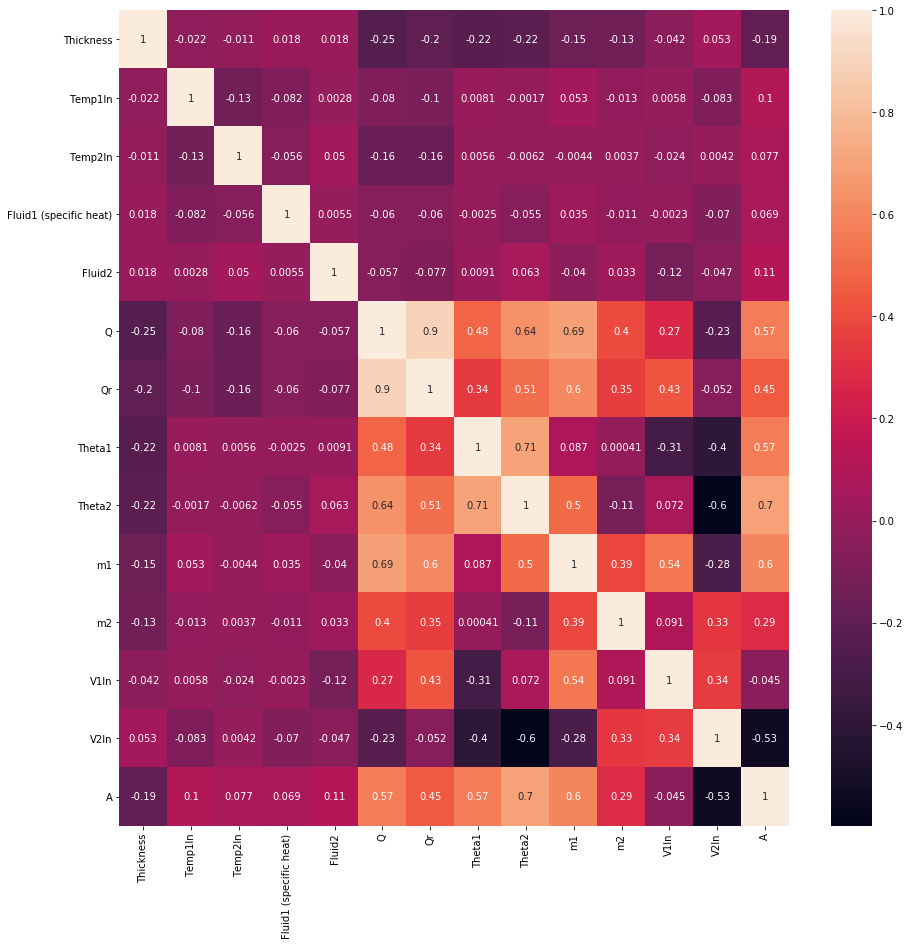

In [12]:
# Checking if there are highly correlated feature if exist in data
plt.figure(figsize= (15,15))
sns.heatmap(df_clipped.corr(method = 'spearman'), annot = True)
plt.show()

###### Observation from Correlation is that the column Q an Qr are highly correlated

In [13]:
#  TSNE
ss = StandardScaler().fit_transform(df_clipped)
ts = TSNE(n_components = 2, perplexity = 30)
TSNE_data = ts.fit_transform(ss)

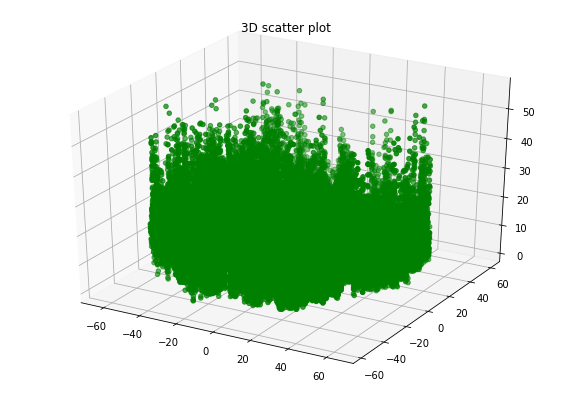

In [14]:
# Creating Scatter Plot figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(TSNE_data[:,0], TSNE_data[:,1] , y, color = "green")
plt.title("3D scatter plot")
# show plot
plt.show()

In [15]:
def box_dist_plot(x):
    fig, ax = plt.subplots(1,2, figsize = (10, 5))
    fig.tight_layout()
    sns.boxplot(x, ax = ax[0], orient = 'v')
    sns.distplot(x, ax = ax[1])
    

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 18.0
Data in Percentile 10 is 33.0
Data in Percentile 20 is 42.0
Data in Percentile 30 is 50.0
Data in Percentile 40 is 56.0
Data in Percentile 50 is 60.0
Data in Percentile 60 is 64.0
Data in Percentile 70 is 68.0
Data in Percentile 80 is 72.0
Data in Percentile 90 is 76.0
Data in Percentile 100 is 86.0


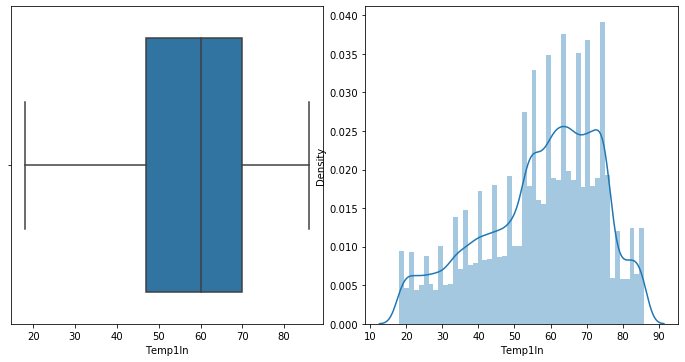

In [16]:
#Temp1In
box_dist_plot(df_clipped['Temp1In'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Temp1In'],j)))

+ It seems there are no outliers in TempIn

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 15.0
Data in Percentile 10 is 18.0
Data in Percentile 20 is 29.0
Data in Percentile 30 is 38.0
Data in Percentile 40 is 50.0
Data in Percentile 50 is 57.0
Data in Percentile 60 is 68.0
Data in Percentile 70 is 75.0
Data in Percentile 80 is 79.0
Data in Percentile 90 is 84.0
Data in Percentile 100 is 90.0


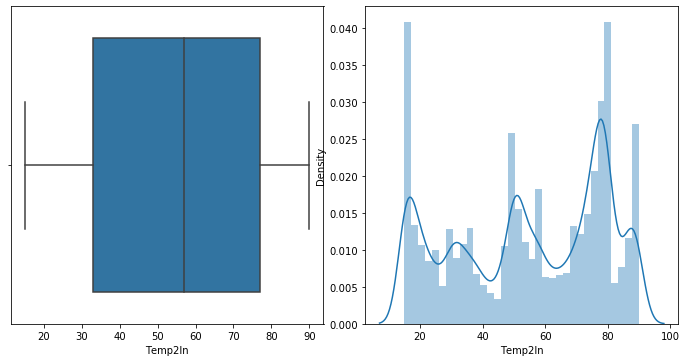

In [17]:
#Temp2In
box_dist_plot(df_clipped['Temp2In'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Temp2In'],j)))

+ Temp2In also does not has any kind of irregularities
+ Density plot shows the data is bimodal in nature

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 1.0
Data in Percentile 10 is 9.0
Data in Percentile 20 is 14.0
Data in Percentile 30 is 17.0
Data in Percentile 40 is 20.0
Data in Percentile 50 is 22.0
Data in Percentile 60 is 35.0
Data in Percentile 70 is 37.0
Data in Percentile 80 is 42.0
Data in Percentile 90 is 44.0
Data in Percentile 100 is 2002.0


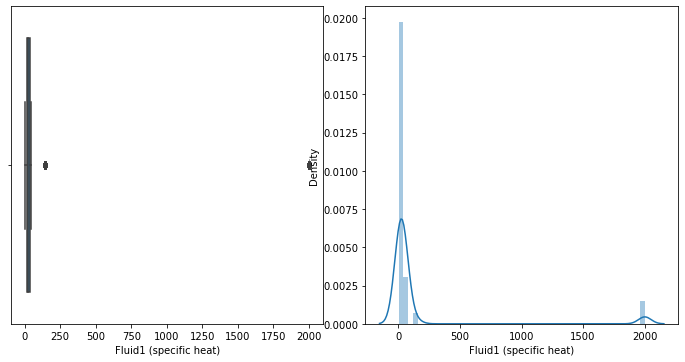

In [18]:
#Fluid1 (specific heat)
box_dist_plot(df_clipped['Fluid1 (specific heat)'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Fluid1 (specific heat)'],j)))

In [19]:
for j in range(90,101,1):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Fluid1 (specific heat)'],j)))

Data in Percentile 90 is 44.0
Data in Percentile 91 is 44.0
Data in Percentile 92 is 140.0
Data in Percentile 93 is 140.0
Data in Percentile 94 is 140.0
Data in Percentile 95 is 2001.0
Data in Percentile 96 is 2001.0
Data in Percentile 97 is 2001.0
Data in Percentile 98 is 2002.0
Data in Percentile 99 is 2002.0
Data in Percentile 100 is 2002.0


+ There is five percentile of data which has specific heat 2000+

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 1.0
Data in Percentile 10 is 2.0
Data in Percentile 20 is 11.0
Data in Percentile 30 is 14.0
Data in Percentile 40 is 15.0
Data in Percentile 50 is 21.0
Data in Percentile 60 is 33.0
Data in Percentile 70 is 39.0
Data in Percentile 80 is 43.0
Data in Percentile 90 is 2001.0
Data in Percentile 100 is 2002.0


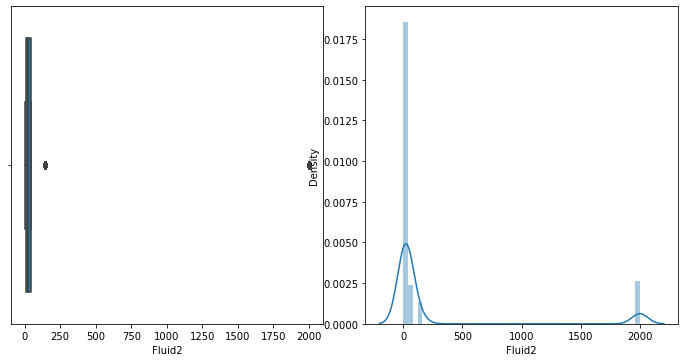

In [20]:
#Fluid2
box_dist_plot(df_clipped['Fluid2'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Fluid2'],j)))

+ 90 percentile of Fkuid specific heat data has value less then 2001 

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.09862531
Data in Percentile 10 is 112.989992
Data in Percentile 20 is 229.24723200000003
Data in Percentile 30 is 346.430314
Data in Percentile 40 is 468.034452
Data in Percentile 50 is 609.7153900000001
Data in Percentile 60 is 786.2051880000001
Data in Percentile 70 is 1024.05316
Data in Percentile 80 is 1391.2583400000005
Data in Percentile 90 is 2055.3230799999997
Data in Percentile 100 is 10865.348999999998


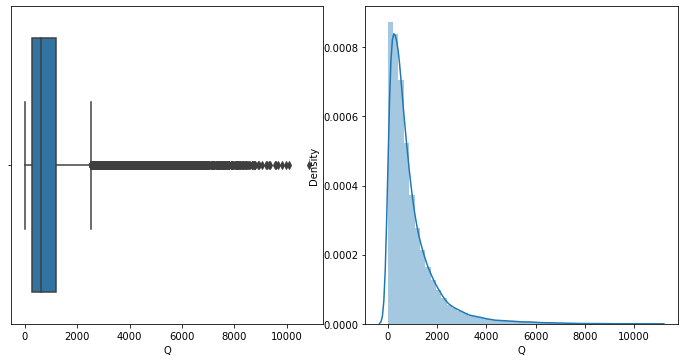

In [21]:
#Q
box_dist_plot(df_clipped['Q'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Q'],j)))

+ 90 percentile of heat transferred is below 2000

In [22]:
for j in range(90,101,1):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Q'],j)))

Data in Percentile 90 is 2055.3230799999997
Data in Percentile 91 is 2164.038356
Data in Percentile 92 is 2288.212524
Data in Percentile 93 is 2439.432476000001
Data in Percentile 94 is 2633.0956
Data in Percentile 95 is 2852.7759999999994
Data in Percentile 96 is 3122.5253319999924
Data in Percentile 97 is 3516.6255080000014
Data in Percentile 98 is 4082.2343360000004
Data in Percentile 99 is 5117.979320000002
Data in Percentile 100 is 10865.348999999998


+ 99 percentile of heat transferred is below 5117.979

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.09862531
Data in Percentile 10 is 97.24952520000001
Data in Percentile 20 is 187.96407200000002
Data in Percentile 30 is 279.335774
Data in Percentile 40 is 378.56052999999997
Data in Percentile 50 is 486.02249000000006
Data in Percentile 60 is 624.886562
Data in Percentile 70 is 808.1166279999998
Data in Percentile 80 is 1094.5576600000002
Data in Percentile 90 is 1689.9171999999999
Data in Percentile 100 is 10865.348999999998


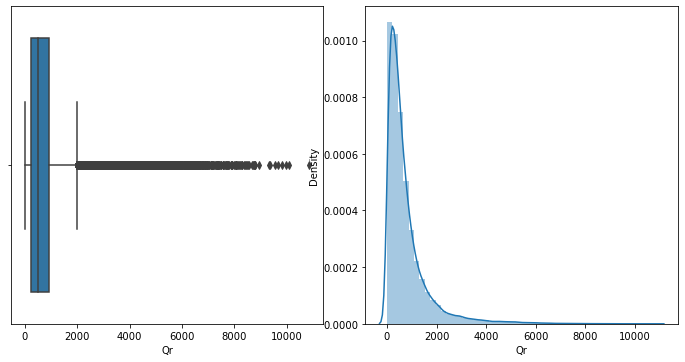

In [23]:
#Qr
box_dist_plot(df_clipped['Qr'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Qr'],j)))

+ 90 percentile of data is below 1689.9

In [24]:
for j in range(90,101,1):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Qr'],j)))

Data in Percentile 90 is 1689.9171999999999
Data in Percentile 91 is 1790.019360000001
Data in Percentile 92 is 1909.6558640000012
Data in Percentile 93 is 2045.163372
Data in Percentile 94 is 2213.6611839999973
Data in Percentile 95 is 2457.8828
Data in Percentile 96 is 2774.1951799999997
Data in Percentile 97 is 3152.440856
Data in Percentile 98 is 3751.5084920000004
Data in Percentile 99 is 4809.485956
Data in Percentile 100 is 10865.348999999998


+ 99 percentile of data is below 4809.486

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.09056443
Data in Percentile 10 is 0.40661292400000004
Data in Percentile 20 is 0.604529262
Data in Percentile 30 is 0.7991678600000001
Data in Percentile 40 is 0.9990657300000001
Data in Percentile 50 is 1.2267188
Data in Percentile 60 is 1.4879786400000001
Data in Percentile 70 is 1.8063802799999995
Data in Percentile 80 is 2.2489778400000002
Data in Percentile 90 is 3.04597362
Data in Percentile 100 is 10.877028


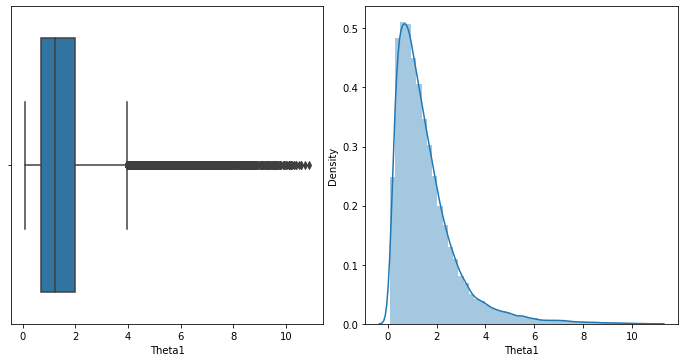

In [25]:
#Theta1
box_dist_plot(df_clipped['Theta1'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Theta1'],j)))

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.0061091
Data in Percentile 10 is 0.12786241199999998
Data in Percentile 20 is 0.221323756
Data in Percentile 30 is 0.33133937
Data in Percentile 40 is 0.46743730000000006
Data in Percentile 50 is 0.63568431
Data in Percentile 60 is 0.8722499520000002
Data in Percentile 70 is 1.20948872
Data in Percentile 80 is 1.7544619600000004
Data in Percentile 90 is 2.9019886599999998
Data in Percentile 100 is 10.996758


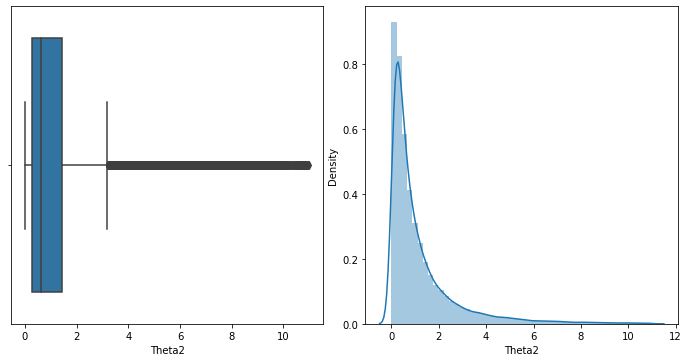

In [26]:
#Theta2
box_dist_plot(df_clipped['Theta2'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['Theta2'],j)))

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.01
Data in Percentile 10 is 3.7894
Data in Percentile 20 is 7.5268000000000015
Data in Percentile 30 is 11.5072
Data in Percentile 40 is 15.736600000000003
Data in Percentile 50 is 20.278
Data in Percentile 60 is 25.211
Data in Percentile 70 is 30.529600799999994
Data in Percentile 80 is 36.39039880000001
Data in Percentile 90 is 42.7152004
Data in Percentile 100 is 49.995998


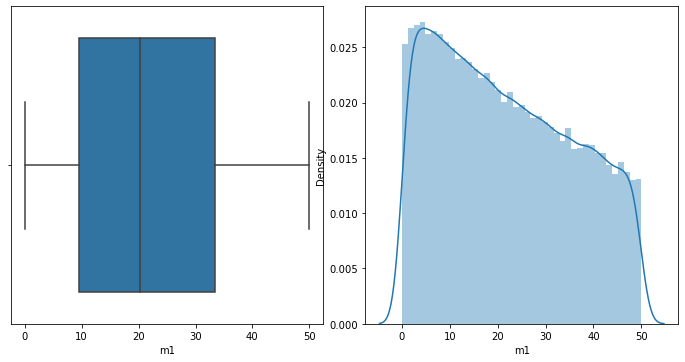

In [27]:
#m1
box_dist_plot(df_clipped['m1'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['m1'],j)))

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.013000000000000001
Data in Percentile 10 is 9.72639996
Data in Percentile 20 is 15.856
Data in Percentile 30 is 20.896998999999997
Data in Percentile 40 is 25.616200600000006
Data in Percentile 50 is 29.895
Data in Percentile 60 is 34.057999
Data in Percentile 70 is 38.120998
Data in Percentile 80 is 42.15120080000001
Data in Percentile 90 is 46.083999999999996
Data in Percentile 100 is 49.997002


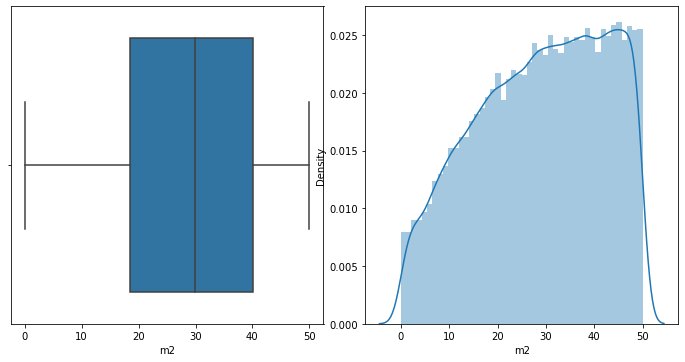

In [28]:
#m2
box_dist_plot(df_clipped['m2'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['m2'],j)))

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.022461593
Data in Percentile 10 is 0.456124288
Data in Percentile 20 is 0.6758113360000001
Data in Percentile 30 is 0.904671752
Data in Percentile 40 is 1.15151218
Data in Percentile 50 is 1.4436985
Data in Percentile 60 is 1.79506476
Data in Percentile 70 is 2.2089252200000002
Data in Percentile 80 is 2.6802001000000004
Data in Percentile 90 is 3.3935707199999996
Data in Percentile 100 is 7.159791900000001


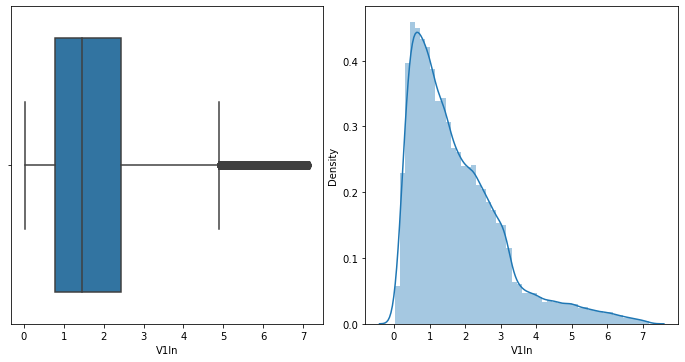

In [29]:
#V1In
box_dist_plot(df_clipped['V1In'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['V1In'],j)))

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.030559825
Data in Percentile 10 is 0.693955734
Data in Percentile 20 is 1.1322669599999997
Data in Percentile 30 is 1.5652311
Data in Percentile 40 is 1.9856282800000002
Data in Percentile 50 is 2.3407687999999998
Data in Percentile 60 is 2.6848179200000004
Data in Percentile 70 is 3.07932376
Data in Percentile 80 is 3.850972820000001
Data in Percentile 90 is 5.047960099999999
Data in Percentile 100 is 11.006449


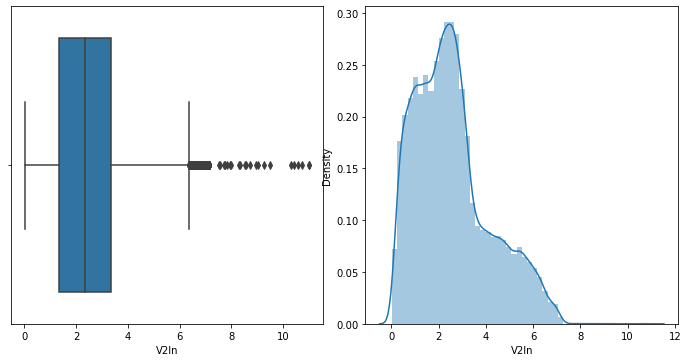

In [30]:
#V2In
box_dist_plot(df_clipped['V2In'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['V2In'],j)))

c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\users\sangram\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Data in Percentile 0 is 0.059999999000000005
Data in Percentile 10 is 10.639999000000001
Data in Percentile 20 is 18.719998999999998
Data in Percentile 30 is 29.759998
Data in Percentile 40 is 47.039997
Data in Percentile 50 is 71.91999799999999
Data in Percentile 60 is 105.4
Data in Percentile 70 is 157.48001000000002
Data in Percentile 80 is 218.5
Data in Percentile 90 is 301.32001
Data in Percentile 100 is 1788.0


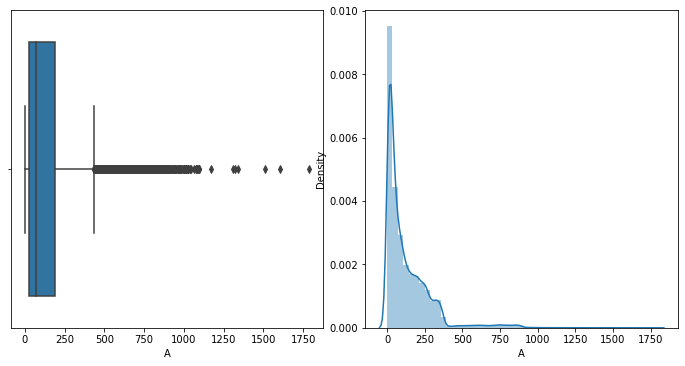

In [31]:
#A
box_dist_plot(df_clipped['A'])
for j in range(0,110,10):
        print('Data in Percentile {} is {}'.format(j, np.percentile(df_clipped['A'],j)))

In [3]:
if not (os.path.exists('train_x.csv') and os.path.exists('train_y.csv')):
    df_clipped.to_csv('train_x.csv')
    y.to_csv('train_y.csv')

In [4]:
if not os.path.exists('train_x_scaled.npy'):
    dfss = StandardScaler()
    dfss.fit(df_clipped)
    df_scaled = dfss.transform(df_clipped)
    np.save('train_x_scaled.npy', df_scaled)
    with open('s_scaler_train.pkl', 'wb') as f:
        pickle.dump(dfss, f)
    f.close()

if not os.path.exists('train_y_scaled.npy'):
    dfyss = StandardScaler()
    dfyss.fit(y)
    y_scaled = dfyss.transform(y)
    np.save('train_y_scaled.npy', y_scaled)
    with open('s_scaler_train_y.pkl', 'wb') as f:
        pickle.dump(dfyss, f)
    f.close()